In [185]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [186]:
!pip install lightgbm

In [187]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [188]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.helpers import binary_ks_curve 
#from scikitplot.metrics import plot_ks_statistic
#from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [189]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

In [190]:
#s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Train"
    
#df1 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202301.parquet")
#df2 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202302.parquet")
#df3 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202303.parquet")
#df4 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202304.parquet")
#df5 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202305.parquet")
#df6 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202306.parquet")
#df7 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202307.parquet")
#df11 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202211.parquet")
#df12 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202212.parquet")

In [191]:
## TARGETS
#tg1 = df1['target1']
#tg2 = df2['target1']
#tg3 = df3['target1']
#tg4 = df4['target1']
#tg5 = df5['target1']
#tg6 = df6['target1']
#tg7 = df7['target1']
#tg11 = df11['target1']
#tg12 = df12['target1']


In [192]:
## unir las cuatro cosechas
#df = pd.concat(  [df1, df2, df3, df4, df5, df6, df7, df11, df12], ignore_index=True)
## unir los cuatro targets
#tg = pd.concat([tg1, tg2, tg3, tg4, tg5, tg6, tg7, tg11, tg12], ignore_index=True)

In [193]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/Target2"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

In [194]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
#df = limpiar_nombres_columnas(df)
dfTrain = limpiar_nombres_columnas(dfTrain)
dfVal = limpiar_nombres_columnas(dfVal)

In [195]:
#listar las columnas del dataframe

def nombres_de_columnas(dataframe):
    return dataframe.columns.tolist()

# Supongamos que tu DataFrame se llama 'df'
# Puedes ajustar el nombre según el que hayas utilizado

#nombres_columnas = nombres_de_columnas(df)
nombres_columnas = nombres_de_columnas(dfTrain)

# Imprimir los nombres de las columnas
print(f'Nombres de columnas: {nombres_columnas}')


Nombres de columnas: ['id_branch', 'id_receiver', 'id_sender_global', '01_receiver_transaction_count', '01_sender_sending_days', '01_branch_working_days', '01_net_amount_receiver', '01_sender_minutes_since_last_transaction_2days', '01_sender_minutes_since_last_transaction_1day', '01_sender_days_to_last_transaction_365', 'sender_days_to_last_transaction_more365', 'day_name_receiver_Friday', 'day_name_receiver_Monday', 'day_name_receiver_Saturday', 'day_name_receiver_Sunday', 'day_name_receiver_Thursday', 'day_name_receiver_Tuesday', 'day_name_receiver_Wednesday', 'id_payout_A', 'id_payout_C', 'id_payout_D', 'id_payout_M', 'id_payout_N', 'id_payout_O', 'id_payout_P', 'id_payout_S', 'id_payout_T', 'id_payout_X', 'target1', 'target_fraudes', 'target']


In [196]:
var_input = ['01_receiver_transaction_count', '01_sender_sending_days', '01_branch_working_days', '01_net_amount_receiver', 
         '01_sender_minutes_since_last_transaction_2days', '01_sender_minutes_since_last_transaction_1day', 
         '01_sender_days_to_last_transaction_365', 'sender_days_to_last_transaction_more365',
        'id_payout_A', 'id_payout_C', 'id_payout_D', 'id_payout_M', 'id_payout_N', 'id_payout_O', 
         'id_payout_P', 'id_payout_S', 'id_payout_T', 'id_payout_X']

##'day_name_receiver_Friday', 'day_name_receiver_Monday', 
##         'day_name_receiver_Saturday', 'day_name_receiver_Sunday', 'day_name_receiver_Thursday', 'day_name_receiver_Tuesday', 
##         'day_name_receiver_Wednesday',

In [197]:
dfTrain.shape

(13120687, 31)

In [198]:
#Ya lo traje dividido en conjuntos de entrenamiento (70%) y prueba (30%)

X_train = dfTrain[var_input]
X_test = dfVal[var_input]
y_train =  dfTrain['target']
y_test =  dfVal['target']

#Uni test y Val
X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

In [199]:
def calcular_porcentaje_valor_1(columna):
    """
    Calcula el porcentaje de ocurrencia del valor 1 en una columna dicotómica.

    Parameters:
    - columna: Columna con valores binarios (0 o 1).

    Returns:
    - Porcentaje de ocurrencia del valor 1.
    """

    total_registros = len(columna)
    ocurrencias_valor_1 = columna.sum()

    porcentaje_valor_1 = (ocurrencias_valor_1 / total_registros) * 100

    return porcentaje_valor_1
porcentaje_1 = calcular_porcentaje_valor_1(Y['target'])
porcentaje_1

0.0022247310169490895

## ENTRENAMIENTO

In [200]:
fit_parameters = {
    #"early_stopping_rounds": 30,           # Número de rondas para detener el entrenamiento si no hay mejoras
    "eval_metric": 'logloss',              # Métrica de evaluación a utilizar (en este caso, logloss)
    "eval_set": [(X_test, y_test)],        # Conjunto de datos de prueba para la evaluación durante el entrenamiento
    'eval_names': ['valid'],               # Nombre asignado al conjunto de evaluación
    #'verbose': 100,                        # Nivel de detalle en la salida durante el entrenamiento
}

In [201]:
# Parámetros para la búsqueda aleatoria de hiperparámetros
param_testeo = {
    "n_estimators": [5, 10, 15, 20, 25, 30, 35, 50, 100, 150, 300, 400, 500, 510, 520],
    # Número de estimadores (árboles) a probar

    "num_leaves": [2, 3, 4, 6, 10, 20, 25, 28, 30, 31, 32, 33, 35, 40, 45],
    # Número máximo de nodos hoja en un árbol

    "max_depth": [10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 35, 100, 125, 150, 170, 200, 250, 300, 400],
    # Profundidad máxima de un árbol

    "colsample_bytree": [0.50, 0.55, 0.6, 0.65, 0.68, 0.70, 0.71, 0.80, 0.81, 0.84, 0.85, 0.86, 0.9],
    # Fracción de características a considerar en cada árbol

    "min_child_weight": [0.001, 0.002, 0.0025, 0.0026, 0.0027, 0.003, 0.004, 0.005, 0.007, 0.008, 0.009],
    # Peso mínimo necesario para crear un nuevo nodo en el árbol

    "learning_rate": [0.1, 0.02, 0.03, 0.04, 0.07, 0.005, 0.003, 0.001],
    # Tasa de aprendizaje del modelo

    'subsample': [1],
    # Fracción de muestras a utilizar para el entrenamiento de cada árbol

    "objective": ['binary'],
    # Tipo de problema a resolver (clasificación binaria en este caso)

    "importance_type": ["gini", "entropy"],
    # Tipo de importancia de las características

    "boosting_type": ["dart", "goss", "rf", "gbdt"],
    # Tipo de boosting a probar
    
    #"is_unbalance": ['True'],

    "scale_pos_weight" : [0.002, 0.003] ,
}


{'subsample': 1,
 'scale_pos_weight': 0.002,
 'objective': 'binary',
 'num_leaves': 30,
 'n_estimators': 500,
 'min_child_weight': 0.0027,
 'max_depth': 25,
 'learning_rate': 0.07,
 'importance_type': 'gini',
 'colsample_bytree': 0.65,
 'boosting_type': 'gbdt'}

In [202]:
# Parámetros para la búsqueda aleatoria de hiperparámetros
param_testeo = {
    "n_estimators": [460, 480, 400,  500, 510, 520, 530],
    # Número de estimadores (árboles) a probar

    "num_leaves": [ 25, 26, 28, 30, 32, 34, 35],
    # Número máximo de nodos hoja en un árbol

    "max_depth": [ 22, 23, 24, 25, 26, 27, 28],
    # Profundidad máxima de un árbol

    "colsample_bytree": [ 0.6, 0.62, 0.65, 0.68],
    # Fracción de características a considerar en cada árbol

    "min_child_weight": [ 0.0025, 0.0026, 0.0027, 0.0031, 0.0033 ],
    # Peso mínimo necesario para crear un nuevo nodo en el árbol

    "learning_rate": [0.05,0.06, 0.07, 0.005, 0.001],
    # Tasa de aprendizaje del modelo

    'subsample': [1],
    # Fracción de muestras a utilizar para el entrenamiento de cada árbol

    "objective": ['binary'],
    # Tipo de problema a resolver (clasificación binaria en este caso)

    "importance_type": ["gini", "entropy"],
    # Tipo de importancia de las características

    "boosting_type": ["dart", "goss", "rf", "gbdt"],
    # Tipo de boosting a probar
    
    #"is_unbalance": ['True'],

    "scale_pos_weight" : [0.001, 0.0008] ,
}


In [203]:
# Número de combinaciones de hiperparámetros a probar durante la búsqueda aleatoria
n_HP_points_to_test = 100


In [204]:
def entrenar_modelo_con_busqueda_aleatoria(X, Y, fit_parameters, param_testeo, n_HP_points_to_test=100, random_state=87):
    """
    Entrena un modelo utilizando LightGBM con búsqueda aleatoria de hiperparámetros.

    Parameters:
    - X: Características del conjunto de datos.
    - Y: Etiquetas del conjunto de datos.
    - fit_parameters: Parámetros para el entrenamiento y evaluación del modelo.
    - param_testeo: Parámetros para la búsqueda aleatoria de hiperparámetros.
    - n_HP_points_to_test: Número de combinaciones de hiperparámetros a probar (predeterminado: 100).
    - random_state: Semilla aleatoria para reproducibilidad (predeterminado: 87).

    Returns:
    - Objeto de resultados de RandomizedSearchCV.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

    # Limpiar y estandarizar los nombres de las columnas (llamando a la función anterior)
    X_train = limpiar_nombres_columnas(X_train)
    X_test = limpiar_nombres_columnas(X_test)

    # Crear un clasificador LightGBM y realizar una búsqueda aleatoria de hiperparámetros
    lgbm = LGBMClassifier(random_state=random_state)
    result_trainRandom = RandomizedSearchCV(
                        estimator=lgbm, 
                        param_distributions=param_testeo, 
                        n_iter=n_HP_points_to_test,
                        scoring='f1_micro',
                        cv=3,
                        refit=True,
                        random_state=random_state,
                        verbose=True)

    # Entrenar el modelo utilizando los datos de entrenamiento y los parámetros de ajuste
    result_trainRandom.fit(X_train, y_train, **fit_parameters)

    return result_trainRandom
   


In [205]:
#result = entrenar_modelo_con_busqueda_aleatoria(X, Y, fit_parameters, param_testeo, n_HP_points_to_test=100, random_state=87)

In [206]:
#result.best_params_

{'subsample': 1,
 'scale_pos_weight': 0.002,
 'objective': 'binary',
 'num_leaves': 30,
 'n_estimators': 500,
 'min_child_weight': 0.0027,
 'max_depth': 25,
 'learning_rate': 0.07,
 'importance_type': 'gini',
 'colsample_bytree': 0.65,
 'boosting_type': 'gbdt'}

In [207]:
#lgb_classifier = LGBMClassifier(**result.best_params_)

In [208]:
#experimento 1
lgb_classifier = LGBMClassifier(subsample= 1, objective = 'binary', num_leaves= 26, n_estimators= 500, min_child_weight=0.0026, max_depth= 27, learning_rate= 0.07, importance_type='entropy', colsample_bytree= 0.62 ,boosting_type='dart', scale_pos_weight= 0.001, num_boost_round = 30)
#lgb_classifier = LGBMClassifier(subsample= 1, objective = 'binary', num_leaves= 31, min_child_weight=0.009, max_depth= 19, learning_rate= 0.05, importance_type='entropy', colsample_bytree= 0.6 ,boosting_type='dart', is_unbalance='True', num_boost_round = 30)

In [209]:
X_train.head()

,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,id_payout_A,id_payout_C,id_payout_D,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X
3971984,0.099010,0.337500,0.381352,0.505415,0.0,0.0,0.805479,0,False,False,False,False,False,False,True,False,False,False
13473242,0.000000,0.000000,0.019956,0.108303,0.0,0.0,0.441096,0,False,False,False,False,False,False,True,False,False,False
16030697,0.346535,0.328571,0.381184,0.068592,0.0,0.0,0.000000,1,False,True,False,False,False,False,False,False,False,False
12871639,0.089109,0.048214,0.525239,0.097473,0.0,0.0,0.482192,0,False,False,False,False,False,False,True,False,False,False
12773052,0.128713,0.960714,0.275197,0.036101,0.0,0.0,0.326027,0,False,False,False,False,False,False,True,False,False,False


In [210]:
X.head()

,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,id_payout_A,id_payout_C,id_payout_D,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X
0,0.099010,0.337500,0.381352,0.505415,0.0,0.0,0.805479,0,False,False,False,False,False,False,True,False,False,False
1,0.000000,0.000000,0.019956,0.108303,0.0,0.0,0.441096,0,False,False,False,False,False,False,True,False,False,False
2,0.346535,0.328571,0.381184,0.068592,0.0,0.0,0.000000,1,False,True,False,False,False,False,False,False,False,False
3,0.089109,0.048214,0.525239,0.097473,0.0,0.0,0.482192,0,False,False,False,False,False,False,True,False,False,False
4,0.128713,0.960714,0.275197,0.036101,0.0,0.0,0.326027,0,False,False,False,False,False,False,True,False,False,False


In [211]:
import lightgbm as lgb
train_data  = lgb.Dataset(X_train, label = y_train)
#model = lgb.train(params, train_data, num_boost_round=5)

lgb_classifier.fit(np.array(X_train), y_train)
#lgb_classifier.fit(train_data)
lbg_predictions_labels = lgb_classifier.predict(X_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=30, num_boost_round=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Info] Number of positive: 287, number of negative: 13120400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1640
[LightGBM] [Info] Number of data points in the train set: 13120687, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000022 -> initscore=-10.730197
[LightGBM] [Info] Start training from score -10.730197


In [212]:
# modelo train
data1_f_data_pred_rf= lgb_classifier.predict(X)     
probab_rf = lgb_classifier.predict_proba(X)

score_rf=np.delete(probab_rf, np.s_[0], axis=1) 
Y_c=Y.copy()
Y_c['preds_rf'] = data1_f_data_pred_rf
Y_c['score_rf'] = score_rf

In [213]:
# Realizar predicciones con el modelo entrenado en el conjunto de entrenamiento
data1_f_data_pred_rf = lgb_classifier.predict(X)

# Obtener las probabilidades predichas para la clase positiva (clase 1) del modelo
probab_rf = lgb_classifier.predict_proba(X)

# Extraer las puntuaciones (probabilidades) asociadas con la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Crear una copia de las etiquetas verdaderas (Y) para análisis adicional
Y_c = Y.copy()

# Agregar las predicciones y las puntuaciones del modelo a las etiquetas verdaderas
Y_c['preds_rf'] = data1_f_data_pred_rf
Y_c['score_rf'] = score_rf

# Los datos ahora contienen etiquetas verdaderas, predicciones y puntuaciones del modelo
# Puedes utilizar estos resultados para realizar análisis y evaluar el rendimiento del modelo.


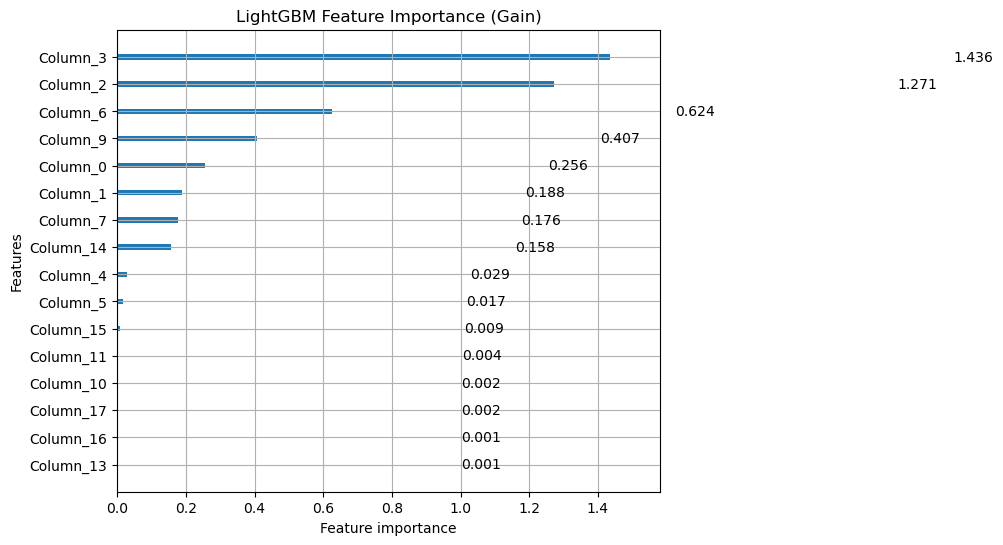

In [214]:
lgb.plot_importance(lgb_classifier, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

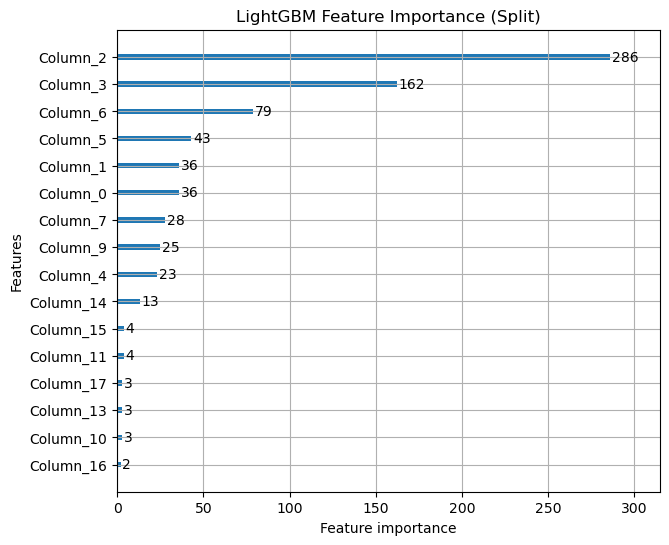

In [215]:
# Plot feature importance using Split
lgb.plot_importance(lgb_classifier, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [216]:
X

,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,id_payout_A,id_payout_C,id_payout_D,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X
0,0.099010,0.337500,0.381352,0.505415,0.0,0.0,0.805479,0,False,False,False,False,False,False,True,False,False,False
1,0.000000,0.000000,0.019956,0.108303,0.0,0.0,0.441096,0,False,False,False,False,False,False,True,False,False,False
2,0.346535,0.328571,0.381184,0.068592,0.0,0.0,0.000000,1,False,True,False,False,False,False,False,False,False,False
3,0.089109,0.048214,0.525239,0.097473,0.0,0.0,0.482192,0,False,False,False,False,False,False,True,False,False,False
4,0.128713,0.960714,0.275197,0.036101,0.0,0.0,0.326027,0,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18743834,0.217822,0.335714,0.531779,0.021300,0.0,0.0,0.728767,0,False,False,False,False,False,False,False,False,False,True
18743835,0.079208,0.666071,0.120745,0.387004,0.0,0.0,0.917808,0,False,False,False,False,False,False,True,False,False,False
18743836,0.000000,0.000000,0.247694,0.032491,0.0,0.0,0.000000,0,False,False,False,True,False,False,False,False,False,False
18743837,0.722772,0.733929,0.805635,0.137906,0.0,0.0,0.827397,0,False,False,False,False,False,False,True,False,False,False


In [217]:
 Y_c[Y_c['target'] == True]

,target,preds_rf,score_rf
17278,True,False,0.000106
93895,True,False,0.000004
163186,True,False,0.000012
179200,True,False,0.000005
251371,True,False,0.000011
...,...,...,...
18617019,True,False,0.000004
18620045,True,False,0.000005
18657488,True,False,0.000015
18668424,True,False,0.000005


In [218]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,18743422,0
1,417,0


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='score_rf', ylabel='Count'>

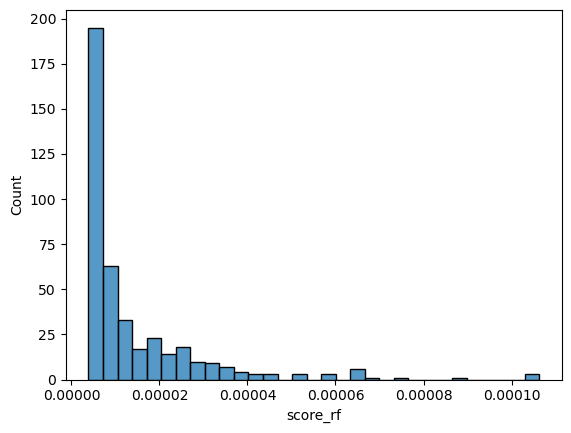

In [219]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [220]:
#sns.histplot(data = Y_c[Y_c['target1'] == False], x='score_rf')

In [221]:
target_names = ['No fraude', 'Fraude']
print(classification_report(Y_c['target'], Y_c['preds_rf'], target_names=target_names))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00  18743422
      Fraude       0.00      0.00      0.00       417

    accuracy                           1.00  18743839
   macro avg       0.50      0.50      0.50  18743839
weighted avg       1.00      1.00      1.00  18743839



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [222]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=10, duplicates='drop').astype(str)

percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
Y_c['FRAUD_DECILE'] = percentiles
print('FRAUD CAPTURA 30%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))

FRAUD CAPTURA 30%:
0.9664268585131894


In [223]:
Y_c['rank'] = pd.qcut(Y_c['score_rf'], q=10, duplicates='drop').astype(str)
Y_c['rank']

0                       (3.8644e-06, 3.8648e-06]
1                        (3.8664e-06, 3.873e-06]
2                       (3.8648e-06, 3.8664e-06]
3           (-6.136000000000001e-06, 3.8642e-06]
4           (-6.136000000000001e-06, 3.8642e-06]
                            ...                 
18743834                (3.8643e-06, 3.8644e-06]
18743835                (3.8644e-06, 3.8648e-06]
18743836                 (3.873e-06, 0.00010632]
18743837    (-6.136000000000001e-06, 3.8642e-06]
18743838                 (3.873e-06, 0.00010632]
Name: rank, Length: 18743839, dtype: object

In [224]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': ['mean', 'min', 'max']}) 

score_rf                    
                  mean       min       max
FRAUD_DECILE                              
1             0.000004  0.000004  0.000106
2             0.000004  0.000004  0.000004
3             0.000004  0.000004  0.000004
4             0.000004  0.000004  0.000004
5             0.000004  0.000004  0.000004
6             0.000004  0.000004  0.000004
7             0.000004  0.000004  0.000004

In [225]:
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
pd.DataFrame(percentiles).value_counts()

score_rf
1           7380149
3           3555717
6           1851014
7           1831352
4           1580314
5           1401317
2           1143976
Name: count, dtype: int64

In [226]:
DECILES_T = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])

In [227]:
DECILES_T

target,False,True
FRAUD_DECILE,,
1,1830956,396
2,1851008,6
3,1401316,1
4,1580314,0
5,3555712,5
6,1143973,3
7,7380143,6


array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

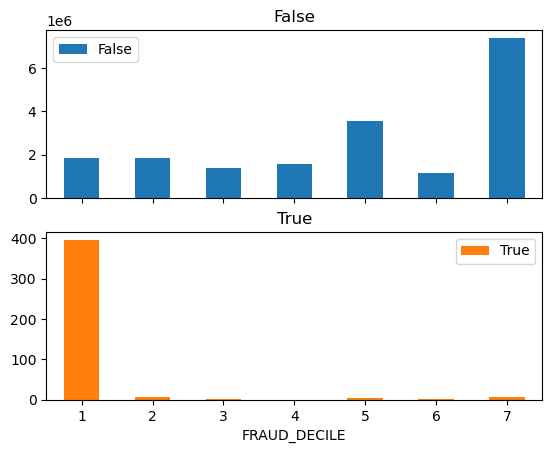

In [228]:
DECILES_T.plot.bar(stacked=False, rot=0,subplots=True)

In [229]:
### Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
#classes = np.unique(Y_c[['target']])
#percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
#percentages = percentages[1:]
#gains = gains[1:]
#gains = gains / percentages
#indice = round(len(gains) * 0.1)
#print('LIFT INV CHURN TRAIN:')
#print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
#print('ROC INV CHURN TRAIN:')
#print(roc_auc_score(Y_c[['target']], Y_c['preds_rf']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
#thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'].ravel())
#print('KS INV CHURN TRAIN:')
#print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
#precision = precision_score(Y_c[['target']], Y_c['preds_rf'])
#recall = recall_score(Y_c[['target']], Y_c['preds_rf'])

#print('Precision INV CHURN TRAIN:')
#print(precision)
#print('Recall INV CHURN TRAIN:')
#print(recall)


## TESTEO ##

In [230]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/Target2"
tes = pd.read_parquet(f"s3://{s3_url}/Test/Test.parquet")

##lista de variables de input
X = tes[var_input]
Y = tes[['target']] 


In [231]:
testeo = tes

In [232]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
testeo = limpiar_nombres_columnas(testeo)

In [233]:
testeo = testeo
#testeo['ID']=testeo['cbs_reg_user_id_cd']
#testeo = testeo.set_index('ID')  
#testeo=testeo.round(2)

 
print ("Dataset Length: ", len(testeo)) 
print ("Dataset Shape: ", testeo.shape)

Dataset Length:  12385170
Dataset Shape:  (12385170, 32)


In [234]:
testeo['target'].value_counts(dropna=False)

target
False    12384979
True          191
Name: count, dtype: int64

In [235]:
testeo.shape

(12385170, 32)

In [236]:
testeo['target'].value_counts(dropna=False)

target
False    12384979
True          191
Name: count, dtype: int64

In [237]:
## Variables del modelo
X_TESTEO = tes[var_input]

In [238]:
X_TESTEO

,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,id_payout_A,id_payout_C,id_payout_D,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X
0,0.049505,1.000000,0.460842,0.180505,0.0,0.0,0.323288,0,False,False,False,False,False,False,True,False,False,False
1,0.584158,1.000000,0.269328,0.357401,0.0,0.0,0.397260,0,False,False,False,False,False,False,True,False,False,False
2,0.019802,1.000000,0.218346,0.036101,0.0,0.0,0.276712,0,False,False,False,False,False,False,True,False,False,False
3,0.910891,1.000000,0.623679,0.036101,0.0,0.0,0.400000,0,False,True,False,False,False,False,False,False,False,False
4,0.217822,0.825000,0.734362,0.216606,0.0,0.0,0.339726,0,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12385165,0.049505,0.060714,0.179272,0.036823,0.0,0.0,0.041096,0,False,False,False,False,False,False,True,False,False,False
12385166,0.009901,0.039286,0.245179,0.036101,0.0,0.0,0.024658,0,False,True,False,False,False,False,False,False,False,False
12385167,0.188119,1.000000,1.000000,0.009747,0.0,0.0,0.000000,0,False,True,False,False,False,False,False,False,False,False
12385168,0.089109,1.000000,0.991112,0.234657,0.0,0.0,0.041096,0,False,True,False,False,False,False,False,False,False,False


In [239]:

# Extrayendo la columna 'target' del DataFrame 'testeo' y creando un nuevo DataFrame 'Y_TESTEO'
Y_TESTEO = testeo[['target']]

# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = lgb_classifier.predict(X_TESTEO)

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = lgb_classifier.predict_proba(X_TESTEO)

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [240]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_TESTEO_c = Y_TESTEO.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_TESTEO_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_TESTEO_c['score_rf'] = score_rf

In [241]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_TESTEO_c['score_rf'], q=10, duplicates='drop').astype(str)
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_TESTEO_c['FRAUD_DECILE'] = np.nan
Y_TESTEO_c['FRAUD_DECILE'] = Y_TESTEO_c['FRAUD_DECILE'].astype('Int32')
Y_TESTEO_c['FRAUD_DECILE'] = percentiles
print('FRAUD CAPTURA 30%:')
print(sum(Y_TESTEO_c[Y_TESTEO_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_TESTEO_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURA 30%:
0.9685863874345549


In [242]:
DECILES = pd.crosstab(Y_TESTEO_c['FRAUD_DECILE'], Y_TESTEO_c['target'])

In [243]:
DECILES

target,False,True
FRAUD_DECILE,,
1,1047873,173
2,1160677,10
3,1415270,2
4,886146,0
5,958844,1
6,1559438,3
7,884502,1
8,4472229,1


array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

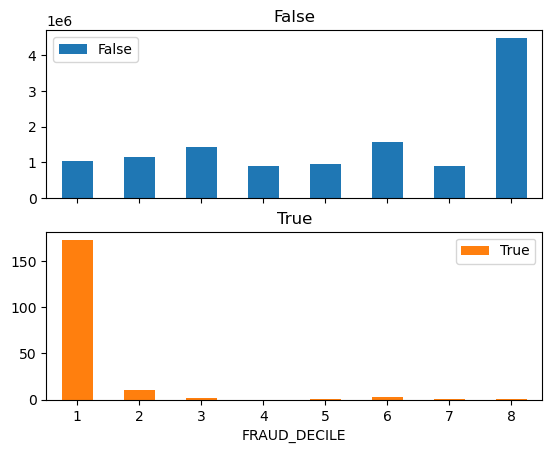

In [244]:
DECILES.plot.bar(stacked=False, rot=0,subplots=True)

In [245]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
#classes = np.unique(Y_TESTEO_c[['target']])
#percentages, gains = cumulative_gain_curve(Y_TESTEO_c[['target']], Y_TESTEO_c['score_rf'], classes[1])
#percentages = percentages[1:]
#gains = gains[1:]
#gains = gains / percentages
#indice = round(len(gains) * 0.1)
#print('LIFT INV CHURN TESTEO:')
#print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
#print('ROC INV CHURN TESTEO:')
#print(roc_auc_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
#thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_TESTEO_c[['target']], Y_TESTEO_c['score_rf'].ravel())
#print('KS INV CHURN TESTEO:')
#print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
#precision = precision_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf'])
#recall = recall_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf'])
#print('Precision INV CHURN TESTEO:')
#print(precision)
#print('Recall INV CHURN TESTEO:')
#print(recall)


In [246]:
# Guardando las importancias de las características (feature importance) en un archivo de texto
# La importancia se mide en términos de ganancia ('gain') según el clasificador LightGBM
# Se utiliza la función 'np.savetxt' para escribir en un archivo de texto
# El archivo se guarda en la ruta './SCORES/importance_1.txt'
# Se utiliza 'lgb_classifier.booster_.feature_importance' para obtener las importancias de las características
# Se especifica el formato de los datos en el archivo como números de punto flotante ('%f')

#np.savetxt('./SCORES/importance_78.txt', lgb_classifier.booster_.feature_importance(importance_type='gain'),fmt='%f')

## Guardo el modelo

In [247]:
#import joblib
# save model
#joblib.dump(lgb_classifier, 'ModeloV1T2.pkl')
# load model
#gbm_pickle = joblib.load('lgb.pkl')


##TESTEAR TODA LA BASE (sin restricciones de tenure)

In [248]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Train"
    
tes1 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202301.parquet")
tes2 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202302.parquet")
tes3 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202303.parquet")
tes4 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202304.parquet")
tes5 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202305.parquet")
tes6 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202306.parquet")
tes7 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202307.parquet")
tes11 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202211.parquet")
tes12 = pd.read_parquet(f"s3://{s3_url}/Preproc_Fr_202212.parquet")


In [249]:
## unir las cuatro cosechas

tes = pd.concat([tes1, tes2, tes3, tes4, tes5, tes6, tes7, tes11, tes12], ignore_index=True)

In [250]:
tg = tes[['target_fraudes']]

In [251]:
tg['target_fraudes'].value_counts(dropna=False)

target_fraudes
False    18743235
True          604
Name: count, dtype: int64

In [252]:
##lista de variables de input
X = tes[var_input]
Y = tes[['target_fraudes']] 
testeo_f = tes

In [253]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
testeo_f = limpiar_nombres_columnas(testeo_f)

In [254]:
testeo_f = testeo_f

print ("Dataset Length: ", len(testeo_f)) 
print ("Dataset Shape: ", testeo_f.shape)

Dataset Length:  18743839
Dataset Shape:  (18743839, 31)


In [255]:
testeo_f['target_fraudes'].value_counts(dropna=False)

target_fraudes
False    18743235
True          604
Name: count, dtype: int64

In [256]:
X_TESTEO_f = X

In [257]:

# Extrayendo la columna 'target' del DataFrame 'testeo' y creando un nuevo DataFrame 'Y_TESTEO'
Y_TESTEO_f = testeo_f[['target_fraudes']]

# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = lgb_classifier.predict(X_TESTEO_f)

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = lgb_classifier.predict_proba(X_TESTEO_f)

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [258]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_TESTEO_c = Y_TESTEO_f.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_TESTEO_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_TESTEO_c['score_rf'] = score_rf

In [259]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_TESTEO_c['score_rf'], q=10, duplicates='drop').astype(str)
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_TESTEO_c['FRAUD_DECILE'] = np.nan
Y_TESTEO_c['FRAUD_DECILE'] = Y_TESTEO_c['FRAUD_DECILE'].astype('Int32')
Y_TESTEO_c['FRAUD_DECILE'] = percentiles
print('FRAUD CAPTURA 30%:')
print(sum(Y_TESTEO_c[Y_TESTEO_c['FRAUD_DECILE'] < 4]['target_fraudes']) / sum(Y_TESTEO_c['target_fraudes']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURA 30%:
0.8609271523178808


In [260]:
DECILES = pd.crosstab(Y_TESTEO_c['FRAUD_DECILE'], Y_TESTEO_c['target_fraudes'])

In [261]:
DECILES

target_fraudes,False,True
FRAUD_DECILE,,
1,1830893,459
2,1850957,57
3,1401313,4
4,1580311,3
5,3555709,8
6,1143950,26
7,7380102,47


array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

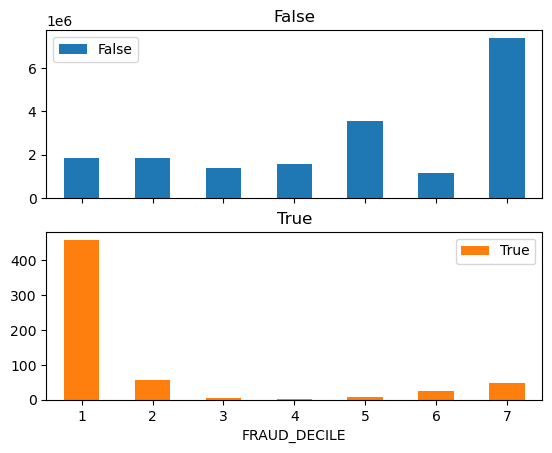

In [262]:
DECILES.plot.bar(stacked=False, rot=0,subplots=True)

In [263]:
Y_TESTEO_c.head()

,target_fraudes,preds_rf,score_rf,FRAUD_DECILE
0,False,False,0.000004,7
1,False,False,0.000004,7
2,False,False,0.000004,7
3,False,False,0.000004,5
4,False,False,0.000004,7


In [264]:
Y_TESTEO_c.dtypes

target_fraudes       bool
preds_rf             bool
score_rf          float64
FRAUD_DECILE        int64
dtype: object

In [265]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_TESTEO_c[['target']])
percentages, gains = cumulative_gain_curve(Y_TESTEO_c[['target']], Y_TESTEO_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT INV CHURN TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC INV CHURN TESTEO:')
print(roc_auc_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_TESTEO_c[['target']], Y_TESTEO_c['score_rf'].ravel())
print('KS INV CHURN TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf'])
recall = recall_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf'])
print('Precision INV CHURN TESTEO:')
print(precision)
print('Recall INV CHURN TESTEO:')
print(recall)



KeyError: "None of [Index(['target'], dtype='object')] are in the [columns]"

In [ ]:
testeo_f2 = testeo_f2.reset_index()

In [ ]:
testeo_f2.head()

In [ ]:
testeo_f2.dtypes

In [ ]:
Y_TESTEO_c['ID'] = Y_TESTEO_c['ID'].astype(int)

In [ ]:
testeo_f2['ID'] = testeo_f2['ID'].astype(int)

In [ ]:
testeo_all10dec2023 = pd.merge(testeo_f2, Y_TESTEO_c, how="left", on=["ID"])

In [ ]:
testeo_all10dec2023.head()

In [ ]:
testeo_all10dec2023= testeo_all10dec2023[['cbs_reg_user_id_cd', 'target','preds_rf','score_rf','CHURNINV_DECILE','tenure_m']]

In [ ]:
testeo_all10dec2023.to_csv('testeo_60Mx10dec2023.csv')